### Fundamentals of Natural Language Processing
# Negation and Uncertainty Detection using a Rule-Based System

*Authors:*

> *Anna Blanco, Agustina Lazzati, Stanislav Bultaskii, Queralt Salvadó*

*Aims:*
>The objective is to develop a rule-based system for detecting negation and uncertainty cues in natural language text. The system aims to identify words or phrases that express negation (e.g., "not", "never") or uncertainty (e.g., "maybe", "could") within sentences.


---



## Downloading the data
In this project, we download the training and test data from remote sources using predefined URLs. These datasets contain text annotated with labels for negation and uncertainty cues, which are crucial for training and evaluating the rule-based detection system.

In [13]:
import json
import re
import requests
import pandas as pd
import nltk
import spacy
import string

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

try:
    nlp = spacy.load("es_core_news_sm")
except OSError:
    print("Downloading Spanish model for spaCy...")
    spacy.cli.download("es_core_news_sm")
    nlp = spacy.load("es_core_news_sm")


def load_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        try:
            data = json.loads(response.text)
            return data
        except json.JSONDecodeError:
            print(f"Failed to parse JSON data from {url}")
            print(f"First 500 characters of response: {response.text[:500]}")
            return None
    else:
        print(f"Failed to load data: {response.status_code}")
        return None

In [14]:
train_url = 'https://raw.githubusercontent.com/AgustinaLazzati/NLP-Project/refs/heads/Test/negacio_train_v2024.json'
test_url = 'https://raw.githubusercontent.com/AgustinaLazzati/NLP-Project/refs/heads/Test/negacio_test_v2024.json'

## Preprocessing the Data
Before feeding the text into the model, we preprocess it to standardize and clean the input. This involves converting the text to lowercase, removing unwanted characters (like asterisks), and normalizing any excessive whitespace. These steps ensure that the text is in a consistent format, improving the accuracy and reliability of the model during both training and testing.

In [15]:
def preprocess_text(text):
    if not isinstance(text, str) or not text:
        return ""

    # Convert text to lowercase
    text = text.lower()

    # Remove asterisks
    text = re.sub(r'\*+', ' ', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

## Extracting Negations and Uncertainties
To better understand the presence of negations and uncertainties in the text, we extract these specific spans from the dataset. The function scans through the dataset, retrieving unique spans labeled as "NEG" for negations and "UNC" for uncertainties. This step helps isolate the text portions that are crucial for further analysis or rule-based systems, such as detecting how uncertainty or negation influences the meaning of the text.

In [16]:
def extract_negations_and_uncertainties(data):
    """
    Extracts all unique negation ('NEG') and uncertainty ('UNC') spans from a DataFrame.
    Parameters:
    - df: Pandas DataFrame where each row contains 'data' and 'predictions' columns.

    Returns:
    - negations: List of unique negation text spans.
    - uncertainties: List of unique uncertainty text spans.
    """
    negations = set()
    uncertainties = set()

    for _, row in data.iterrows():
        # Safely get text and predictions
        text = row.get("data", {}).get("text", "")
        predictions = row.get("predictions", [])

        for pred in predictions:
            if not isinstance(pred, dict):
                continue

            for annotation in pred.get("result", []):
                if not isinstance(annotation, dict):
                    continue

                if annotation.get("type") == "labels":
                    labels = annotation.get("value", {}).get("labels", [])
                    if not labels:
                        continue

                    label = labels[0]
                    start = annotation.get("value", {}).get("start", 0)
                    end = annotation.get("value", {}).get("end", 0)
                    span = text[start:end].strip()

                    if label == "NEG":
                        negations.add(span)
                    elif label == "UNC":
                        uncertainties.add(span)

    return list(negations), list(uncertainties)

## Text Labeling Pipeline
The Text Labeling Pipeline focuses on extracting tagged text and assigning labels to each word in the input text. First, the function retrieves the start and end positions of tagged text and the corresponding labels. Then, it processes each word in the text, comparing the position of the word to the labels and assigning the correct tag to each word.

This system ensures that words are appropriately labeled based on their position in the text, allowing for a precise understanding of how different parts of the text are categorized.

In [17]:
def extract_tag_info(df, row_index):
    """
    Extracts tagged text information for a given row from the dataframe.

    Parameters:
    - df: The DataFrame containing the data and predictions.
    - row_index: The index of the row from which information is extracted.

    Returns:
    - A list of tuples containing (start, end, extracted text, word count, tag label).
    """
    # Get predictions and corresponding text from the specified row
    predictions = df.loc[row_index, "predictions"][0]["result"]
    text = df.loc[row_index, "data"]["text"]

    results = []

    for entry in predictions:
        # Destructure the values for easy access
        start, end = entry["value"]["start"], entry["value"]["end"]
        extracted_text = text[start:end]
        word_count = len(extracted_text.rstrip().split())
        label = entry["value"]["labels"][0]

        # Append the tuple to the results list
        results.append((start, end, extracted_text, word_count, label))

    return results

def get_nextWord(text, end_chars):
    """
    Extracts the next word and its start position from the given text.
    Parameters:
    - text: The input string from which words are extracted.
    - end_chars: Characters that mark the end of a word.

    Yields:
    - Tuple of (start_position, word) for each word in the text.
    """
    word_start = None
    word = []

    # Loop through the text with index and character
    for index, char in enumerate(text):
        # If the character is part of the word (not space or end character)
        if char != ' ' and char not in end_chars:
            if word_start is None:  # Mark the start position of the word
                word_start = index
            word.append(char)

        # If a word is completed (space or end character encountered)
        elif word:
            yield (word_start, ''.join(word))  # Yield the word and its start position
            word = []
            word_start = None

    # If there's any remaining word after the loop, yield it
    if word:
        yield (word_start, ''.join(word))

def label_text(df, number_row, word_ending):
    text = df["data"][number_row]["text"]
    labels = sorted(extract_tag_info(df, number_row), key=lambda x: x[0])

    if not labels:
        return []

    words = list(get_nextWord(text, word_ending))
    result = []

    for word_start, word in words:
        word_end = word_start + len(word)
        label = 'other'

        # Check all labels to find the most specific one
        for lbl in labels:
            lbl_start, lbl_end, _, _, lbl_type = lbl

            if word[-1] == '.':
              word_end = word_end-1

            if lbl_start <= word_start and word_end <= lbl_end:
                label = lbl_type
                break

        result.append((word, label))

    return result


"""
# Use regex to adjust word_end if there's a dot anywhere in the word
if re.search(r'\.', word):
    word_end = word_start + re.search(r'\.', word).start()

if lbl_start <= word_start and word_end <= lbl_end:
    label = lbl_type
    break
"""


"\n# Use regex to adjust word_end if there's a dot anywhere in the word\nif re.search(r'\\.', word):\n    word_end = word_start + re.search(r'\\.', word).start()\n\nif lbl_start <= word_start and word_end <= lbl_end:\n    label = lbl_type\n    break\n"

## Identifying Negation and Uncertainty Tags
In our Negation and Uncertainty Detection using a Rule-Based System, detecting negation and uncertainty cues is crucial. The function identifies specific negation and uncertainty keywords in the text and assigns labels like NEG or UNC accordingly.

The system then tracks the scope of these cues, tagging all words influenced by the negation or uncertainty until the sentence ends. Words outside this scope are labeled as other. This method allows us to understand how negation and uncertainty affect the meaning of the text.

In [18]:
def get_end_word_definitions():
    sentence_end_chars = "!.?,;:"  # Punctuation marks that signify the end of a sentence
    word_end_chars = ""  # Punctuation marks that signify the end of a word (other than sentence-ending ones)

    # Loop through all punctuation marks and separate sentence-ending characters
    for char in string.punctuation:
        if char not in sentence_end_chars:
            word_end_chars += char  # Add punctuation marks to word_end_chars if they're not in sentence_end_chars

    return sentence_end_chars, word_end_chars


In [19]:
def identify_tags(input_text, sentence_end_chars, word_end_chars, negation_keywords, uncertainty_keywords, neg_scope_size, unc_scope_size):
    """
    Tags words in a sentence with 'NEG', 'UNC', their scopes ('NSCO', 'USCO'), or 'other'.

    The scope of a cue is limited to `neg_scope_size` or `unc_scope_size` tokens, or until a sentence-ending character.

    Parameters:
    - input_text: Text to process.
    - sentence_end_chars: Characters marking sentence boundaries.
    - word_end_chars: Characters marking word boundaries.
    - negation_keywords: List of negation cues.
    - uncertainty_keywords: List of uncertainty cues.
    - neg_scope_size: Integer, scope length for negation.
    - unc_scope_size: Integer, scope length for uncertainty.

    Returns:
    - List of (word, tag) tuples.
    """
    words = list(get_nextWord(input_text, word_end_chars))
    result = []
    scope_active = None
    scope_counter = 0

    for _, word in words:
        if word in negation_keywords:
            tag = 'NEG'
            scope_active = 'NEG'
            scope_counter = neg_scope_size
        elif word in uncertainty_keywords:
            tag = 'UNC'
            scope_active = 'UNC'
            scope_counter = unc_scope_size
        else:
            if scope_active and scope_counter > 0:
                tag = f"{scope_active[0]}SCO"
                scope_counter -= 1
            else:
                tag = 'other'

        result.append((word, tag))

        if any(char in word for char in sentence_end_chars):
            scope_active = None
            scope_counter = 0

    return result


In [20]:
def calculate_predictions(data, sentences, sentences_ends, word_ends, negations, uncertainties, neg_scope_size, unc_scope_size):
    y_pred = []
    for i in range(len(data)):
      pred = identify_tags(sentences[i], sentences_ends, word_ends, negations, uncertainties, neg_scope_size, unc_scope_size)
      y_pred.append(pred)
    return y_pred


def compute_true_labels(data, i, word_ends):
  y_true = []
  for i in range(len(data)):
    y = label_text(data, i, word_ends)
    y_true.append(y)

  return y_true


def align_sentence_lengths(predictions, true_labels):
    """
    This function aligns the lengths of predicted and true sentences by adding placeholder tokens
    (' ', 'other') to the shorter sentence, if necessary, to make both sentences the same length.
    The placeholder ' ' represents an empty space for the word, and 'other' represents a generic tag
    indicating that it's a padding token.
    """
    aligned_preds = []
    aligned_trues = []

    for pred_sentence, true_sentence in zip(predictions, true_labels):
        # Compute the length difference and apply padding accordingly
        if len(true_sentence) > len(pred_sentence):
            aligned_preds.append(pred_sentence + [(' ', 'other')] * (len(true_sentence) - len(pred_sentence)))
            aligned_trues.append(true_sentence)
        elif len(pred_sentence) > len(true_sentence):
            aligned_preds.append(pred_sentence)
            aligned_trues.append(true_sentence + [(' ', 'other')] * (len(pred_sentence) - len(true_sentence)))
        else:
            aligned_preds.append(pred_sentence)
            aligned_trues.append(true_sentence)

    return aligned_trues, aligned_preds


## Evaluation Metrics
To assess the effectiveness of our rule-based system in identifying negation (NEG) and uncertainty (UNC) tags, we define a set of evaluation metrics that focus exclusively on relevant labels. By filtering out tokens tagged as "other", we ensure that precision, recall, accuracy, and F1 score reflect the system's ability to detect only the linguistic cues of interest. These metrics help quantify how well the predicted labels align with the true annotations at the token level.

In [21]:
# Function to compute accuracy focusing only on relevant tags
def compute_accuracy(relevant_labels, y_true, y_pred):
    """
    Computes accuracy while ignoring words labeled as "other".

    Parameters:
    - y_true: List of true labeled sentences.
    - y_pred: List of predicted labeled sentences.

    Returns:
    - Accuracy as a float.
    """
    correct = 0
    total = 0

    for true_seq, pred_seq in zip(y_true, y_pred):
        for (true_word, true_label), (pred_word, pred_label) in zip(true_seq, pred_seq):
            # taken into account only words whose tags are relevant (e.g. NEG or UNC)
            if true_label in relevant_labels:
              total += 1
              if true_word == pred_word and true_label == pred_label:
                  correct += 1

    if total > 0:
      print(f' - Accuracy: {correct / total:.4f}')
      return correct / total
    else:
      return 0.0

def compute_precision(relevant_labels, y_true, y_pred):
    """
    Computes precision while ignoring words labeled as "other".

    Parameters:
    - relevant_labels: Set of labels to consider.
    - y_true: List of true labeled sentences.
    - y_pred: List of predicted labeled sentences.

    Returns:
    - Precision as a float.
    """
    true_positives = 0
    predicted_positives = 0

    for true_seq, pred_seq in zip(y_true, y_pred):
        for (true_word, true_label), (pred_word, pred_label) in zip(true_seq, pred_seq):
            if pred_label not in relevant_labels:  # Ignore predictions that are not in relevant labels
                continue
            predicted_positives += 1
            if true_word == pred_word and true_label == pred_label and true_label in relevant_labels:
                true_positives += 1

    precision = true_positives / predicted_positives if predicted_positives > 0 else 0.0  # Avoid division by zero
    print(f" - Precision: {precision:.4f}")
    return precision

def compute_recall(relevant_labels, y_true, y_pred):
    """
    Computes recall by comparing true and predicted labels while ignoring words labeled as "other".

    Parameters:
    - relevant_labels: Set of labels to consider.
    - y_true: List of true labeled sentences.
    - y_pred: List of predicted labeled sentences.

    Returns:
    - Recall as a float.
    """
    true_positives = 0
    actual_positives = 0

    for true_seq, pred_seq in zip(y_true, y_pred):
        for (true_word, true_label), (pred_word, pred_label) in zip(true_seq, pred_seq):
            if true_label not in relevant_labels:
                continue
            actual_positives += 1
            if true_word == pred_word and true_label == pred_label:
                true_positives += 1

    recall = true_positives / actual_positives if actual_positives > 0 else 0.0
    print(f" - Recall: {recall:.4f}")
    return recall

def compute_f1_score(relevant_labels, y_true, y_pred):
    """
    Computes the F1 score, which is the harmonic mean of precision and recall.

    Parameters:
    - relevant_labels: Set of labels to consider.
    - y_true: List of true labeled sentences.
    - y_pred: List of predicted labeled sentences.

    Returns:
    - F1 score as a float.
    """
    precision = compute_precision(relevant_labels, y_true, y_pred)
    recall = compute_recall(relevant_labels, y_true, y_pred)

    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0

    print(f' - F1_score: {f1:.4f}')
    return f1

## Visualizing Model Performance with Confusion Matrices
To better understand how the rule-based system performs at detecting negation (NEG) and uncertainty (UNC) cues, we visualize its predictions using confusion matrices. These plots provide insight into common misclassifications and help diagnose where the system may be confusing tags. We include both a general token-level confusion matrix and individual binary confusion matrices for each relevant label to assess performance on a per-tag basis.

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    """
    Plots a confusion matrix to visualize the performance of the model at the token level.

    Parameters:
    - y_true: List of true labels for each token in the dataset.
    - y_pred: List of predicted labels for each token in the dataset.

    Returns:
    - A heatmap visualization of the confusion matrix.
    """
    # Get sorted list of all labels
    labels = sorted(list(set(y_true + y_pred)))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=None)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Token-Level)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_per_attribute_confusion_matrices(y_true, y_pred, relevant_labels):
    """
    For each attribute, compute and plot a 2x2 confusion matrix (TP, FP, FN, TN)
    based on presence/absence of the attribute in the predictions.
    Only words with relevant labels in y_true or y_pred will be considered.
    All confusion matrices will be displayed in one grid.
    """
    # Filter out words without relevant labels in either y_true or y_pred
    filtered_y_true = []
    filtered_y_pred = []

    # Go through each pair of sequences in y_true and y_pred
    for true_seq, pred_seq in zip(y_true, y_pred):
        for (true_word, true_label), (pred_word, pred_label) in zip(true_seq, pred_seq):
            # Only consider words that have relevant labels in either true or predicted labels
            if true_label in relevant_labels or pred_label in relevant_labels:
                filtered_y_true.append(true_label)
                filtered_y_pred.append(pred_label)

    # If the filtered lists are empty, exit the function
    if not filtered_y_true or not filtered_y_pred:
        print("No relevant labels found in the data.")
        return

    num_labels = len(relevant_labels)
    grid_size = (num_labels // 2, 2) if num_labels % 2 == 0 else (num_labels // 2 + 1, 2)

    # Create subplots
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 8))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

    # Compute and plot confusion matrix for each relevant label
    for i, label in enumerate(relevant_labels):
        binary_true = [1 if true_label == label else 0 for true_label in filtered_y_true]
        binary_pred = [1 if pred_label == label else 0 for pred_label in filtered_y_pred]

        # Compute confusion matrix: TN, FP, FN, TP
        cm = confusion_matrix(binary_true, binary_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

        # Plot confusion matrix on the corresponding axis
        sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", xticklabels=["Not " + label, label],
                    yticklabels=["Not " + label, label], ax=axes[i])
        axes[i].set_title(f"Confusion Matrix for {label}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='y', rotation=0)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()



In [25]:
def scope_tuning(test_dataframe, all_sentences, sentence_ending, word_ending, neg_cues, unc_cues, y_true):
    best_score = 0
    best_params = (0, 0)

    for neg_scope in range(1, 9):        
        for unc_scope in range(1, 11):  
            y_pred = calculate_predictions(test_dataframe, all_sentences, sentence_ending, word_ending,
                                           neg_cues, unc_cues, neg_scope, unc_scope)

            y_true_ext, y_pred_ext = align_sentence_lengths(y_pred, y_true)

            f1 = compute_f1_score(["NEG", "NSCO", "UNC", "USCO"], y_true, y_pred)

            if f1 > best_score:
                best_score = f1
                best_params = (neg_scope, unc_scope)

    print(f"Best Scope Sizes — Negation: {best_params[0]}, Uncertainty: {best_params[1]} with F1: {best_score:.4f}")
    return best_params

## Running the Full Evaluation Pipeline
In this final section, we bring together all the components of our rule-based system for detecting negation and uncertainty in text. The `main()` function orchestrates the entire pipeline—from loading and preprocessing the data to extracting linguistic cues, generating predictions, and evaluating performance. It computes key metrics such as accuracy and F1-score for both overall and per-label analysis, and visualizes the system's effectiveness using confusion matrices. This integrated workflow provides a comprehensive overview of how well the rule-based approach performs on unseen test data.


Loading training data...
Loading test data...
Processing training cues...
Preprocessing test dataset...
Calculating true labels...
Tuning scope parameters...
 - Precision: 0.7942
 - Recall: 0.3841
 - F1_score: 0.5178
 - Precision: 0.7895
 - Recall: 0.4002
 - F1_score: 0.5312
 - Precision: 0.7824
 - Recall: 0.4122
 - F1_score: 0.5399
 - Precision: 0.7773
 - Recall: 0.4223
 - F1_score: 0.5472
 - Precision: 0.7710
 - Recall: 0.4302
 - F1_score: 0.5523
 - Precision: 0.7650
 - Recall: 0.4348
 - F1_score: 0.5545
 - Precision: 0.7597
 - Recall: 0.4376
 - F1_score: 0.5553
 - Precision: 0.7547
 - Recall: 0.4397
 - F1_score: 0.5557
 - Precision: 0.7497
 - Recall: 0.4412
 - F1_score: 0.5555
 - Precision: 0.7450
 - Recall: 0.4424
 - F1_score: 0.5552
 - Precision: 0.7816
 - Recall: 0.4997
 - F1_score: 0.6097
 - Precision: 0.7785
 - Recall: 0.5158
 - F1_score: 0.6205
 - Precision: 0.7733
 - Recall: 0.5278
 - F1_score: 0.6274
 - Precision: 0.7695
 - Recall: 0.5379
 - F1_score: 0.6332
 - Precision: 0

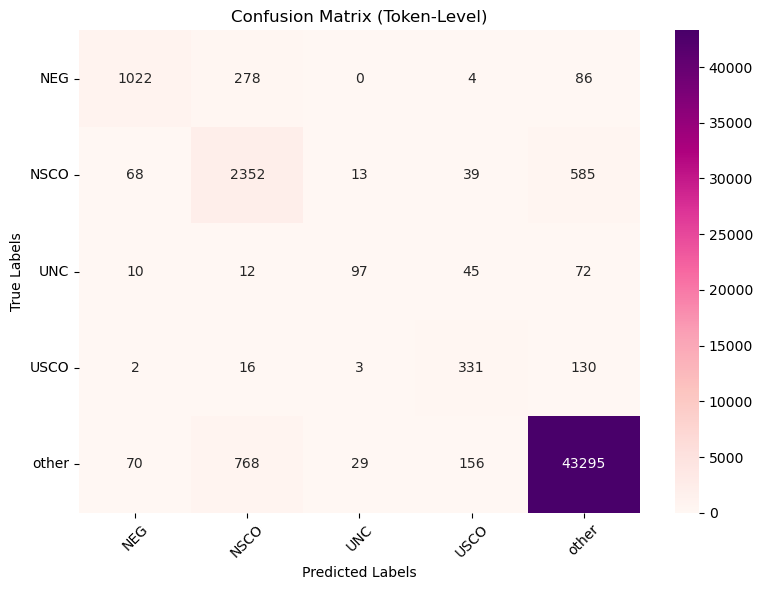


Visualizing the results Per-Label (Only words with relevant labels will be considered)...


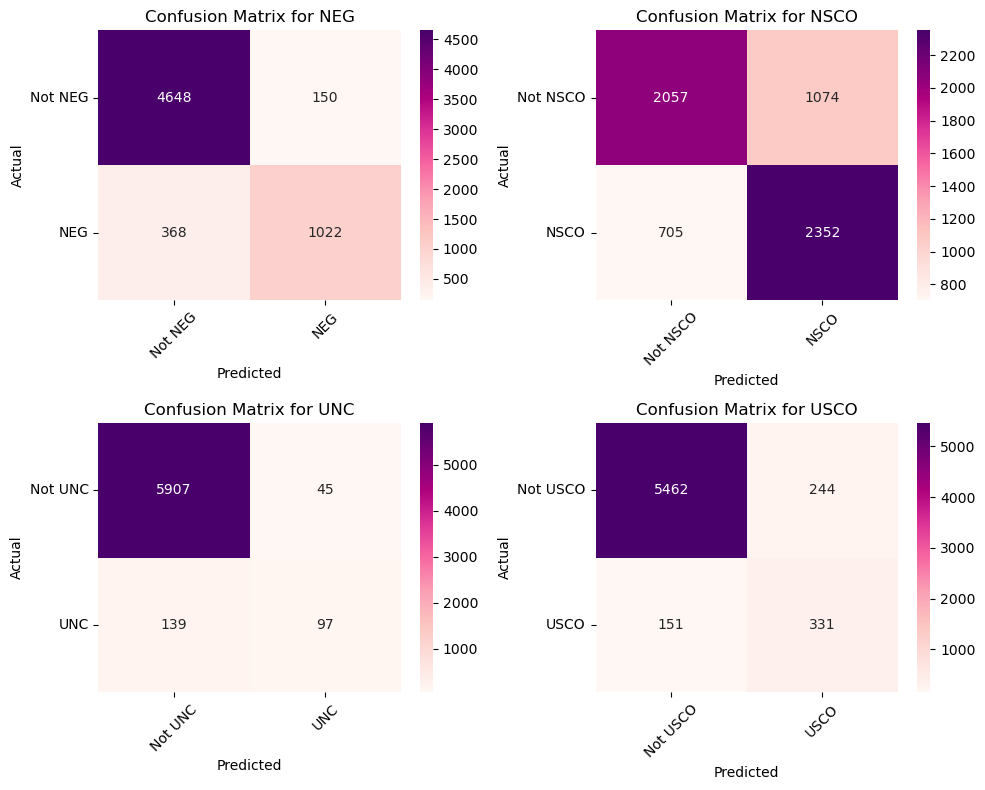

In [26]:
def main():
    # Training Data
    print("\nLoading training data...")
    train_data = load_data(train_url)
    train_dataframe = pd.DataFrame(train_data)

    # Test Data
    print("Loading test data...")
    test_data = load_data(test_url)
    test_dataframe = pd.DataFrame(test_data)

    # Exit if the data could not be loaded
    if not train_data or not test_data:
        print("Failed to load data. Exiting. ---------------------")
        exit()
    print("Processing training cues...")
    # extract list of negations and uncertainties from the train data
    NEGATION_CUES, UNCERTAINTY_CUES = extract_negations_and_uncertainties(train_dataframe)

    # Get the ending of each sentence and words
    sentence_ending, word_ending = get_end_word_definitions()

    print("Preprocessing test dataset...")
    # Preprocess each sentence
    all_sentences = []
    for i in range(len(test_dataframe)):
        sentence = preprocess_text(test_dataframe["data"][i]["text"])
        all_sentences.append(sentence)


    print("Calculating true labels...")
    y_true = compute_true_labels(test_dataframe, i, word_ending)

    print("Tuning scope parameters...")
    best_neg_scope, best_unc_scope = scope_tuning(test_dataframe, all_sentences, sentence_ending, word_ending, NEGATION_CUES, UNCERTAINTY_CUES, y_true)

    print("Generating predictions with best scope...")
    y_pred = calculate_predictions(test_dataframe, all_sentences, sentence_ending, word_ending, NEGATION_CUES, UNCERTAINTY_CUES, best_neg_scope, best_unc_scope)

    y_true_ext, y_pred_ext = align_sentence_lengths(y_pred, y_true)

    print("\n-----Printing some examples-----")
    print()
    print(f"Prediction Sample {1}: {y_pred_ext[0]}")
    print(f"Correct Sample {1}: {y_true_ext[0]}\n")

    # define list of relevant labels to compute accuracy
    relevant_labels = ["NEG", "NSCO", "UNC", "USCO"]

    # Overall metrics
    print(f"\n----- Overall Evaluation -----")
    compute_accuracy(relevant_labels, y_true_ext, y_pred_ext)
    compute_f1_score(relevant_labels, y_true, y_pred)

    # Per-label metrics
    print(f"\n----- Per-Label Evaluation-----\n")
    for label in relevant_labels:
        print(f"Evaluating {label} cues found: ")
        compute_accuracy([label], y_true_ext, y_pred_ext)
        compute_f1_score([label], y_true, y_pred)
        print()


    y_true_flat = [label for sublist in y_true for _, label in sublist]
    y_pred_flat = [label for sublist in y_pred for _, label in sublist]

    print("\nVisualizing the results...")
    plot_confusion_matrix(y_true_flat, y_pred_flat)

    print("\nVisualizing the results Per-Label (Only words with relevant labels will be considered)...")

    plot_per_attribute_confusion_matrices(y_true_ext, y_pred_ext, relevant_labels)

if __name__ == "__main__":
  main()